In [2]:
%pylab inline

import radical.synapse   as rs
import matplotlib.pyplot as plt
import pandas            as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
import radical.synapse.utils as rsu

In [8]:
cmd   = "mdrun -o traj.trr -e ener.edr -s topol.tpr -g mdlog.log -cpo state.cpt -c outgro"
dburl = "file:///home/merzky/experiments/synapse-wrap-2015/data/"
f     = rs.utils.get_all_frames(cmd, url=dburl)
print f
f     = f.drop(['cmd', 'cmd_idx', 'mem_peak', 'tag_prob', 'tags', 'time_start', 'cpu_sequence', 'mem_sequence', 'sto_sequence'], axis=1)

print "number of data sets: %d" % len(f)

mdrun -o traj.trr -e ener.edr -s topol.tpr -g mdlog.log -cpo state.cpt -c outgro
mdrun -o traj.trr -e ener.edr -s topol.tpr -g mdlog.log -cpo state.cpt -c outgro
mdrun -o traj.trr -e ener.edr -s topol.tpr -g mdlog.log -cpo state.cpt -c outgro
mdrun -o traj.trr -e ener.edr -s topol.tpr -g mdlog.log -cpo state.cpt -c outgro
mdrun -o traj.trr -e ener.edr -s topol.tpr -g mdlog.log -cpo state.cpt -c outgro
mdrun -o traj.trr -e ener.edr -s topol.tpr -g mdlog.log -cpo state.cpt -c outgro
mdrun -o traj.trr -e ener.edr -s topol.tpr -g mdlog.log -cpo state.cpt -c outgro
mdrun -o traj.trr -e ener.edr -s topol.tpr -g mdlog.log -cpo state.cpt -c outgro
mdrun -o traj.trr -e ener.edr -s topol.tpr -g mdlog.log -cpo state.cpt -c outgro
mdrun -o traj.trr -e ener.edr -s topol.tpr -g mdlog.log -cpo state.cpt -c outgro
skip command mdrun -o traj.trr -e ener.edr -s topol.tpr -g mdlog.log -cpo state.cpt -c outgro
   ! command mdrun -nt 1 -o traj.trr -e ener.edr -s topol.tpr -g mdlog.log -cpo state.cpt -c out

In [23]:
host_frames = dict()

steps = sorted(set(f['tag_step']))
rates = sorted(set(f['tag_rate']))
hosts = sorted(set(f['host']), reverse=True)
modes = ['pro', 'emu', 'exe']

# step are int
steps = [int(x) for x in steps]
f['tag_step'] = f['tag_step'].astype(int) 
print "steps: %s" % steps
print "rates: %s" % rates
print "hosts: %s" % hosts
print "modes: %s" % modes

for host in hosts:
    host_frames[host] = dict()
    host_frames[host]['all'] = f[f['host'] == host]
    for mode in modes:
        host_frames[host][mode] = f[(f['tag_rate'] == 1) & (f['mode'] == mode) & (f['host'] == host)]

steps: [10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]
rates: [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
hosts: ['thinkie', 'stampede', 'archer']
modes: ['pro', 'emu', 'exe']


In [24]:
# define a colorscheme we use consistently throughout this notebook
colors   = {'exe'  : 'green'    , 
            'emu'  : 'blue'     , 
            'pro'  : 'red'      ,
            'diff' : 'black'    }
modnames = {'exe'  : 'execution', 
            'emu'  : 'emulation', 
            'pro'  : 'profiling'}

font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

def create_figure(title=None):
    """
    create a plot object and tune its layout to our liking.
    """
    
    fig, ax = plt.subplots(figsize=(10,5))
    if title:
        ax.set_title(title, fontsize=18)
    
    ax.grid(False)

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.02))
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    fig.tight_layout()

    return ax

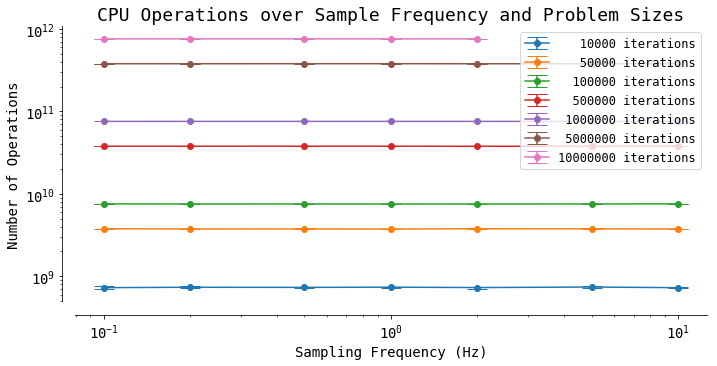

In [25]:
# \subsubsection{P.2 -- Profiling Consistency}

# We performed repeated profiling of the same application instances, in
# the same environment.  While the non-zero standard deviation
# indicates some noise in the measured metrics, the distribution is in
# very good agreement with the distribution of the pure application TTC
# (see figure~\ref{...}), which indicates the influence of system
# background.  The figure shows the same expected profiling consistency
# over a range of application sizes and sampling rates.

ax_ops = create_figure('CPU Operations over Sample Frequency and Problem Sizes')
labels = list()
host   = 'thinkie'

for mode in ['pro']:
  
    for step in steps:
        
        tmp = f[(f['tag_step'] == step) & (f['mode'] == mode) & (f['host'] == host)]
        tmp = tmp[['cpu_ops', 'tag_rate']].groupby('tag_rate')
        
        tmp_means  = tmp.mean()
        tmp_errors = tmp.std()
        
        # we do not have data for some rates, due to limited db size
        if not len(tmp_means):
            continue

        tmp_means.plot(logy=True, logx=True, yerr=tmp_errors, ax=ax_ops, capsize=10, marker='o')
        labels.append ('%8s iterations' % step)

ax_ops.set_xlabel("Sampling Frequency (Hz)", fontsize=14)
ax_ops.set_ylabel("Number of Operations",    fontsize=14)
legend(labels, loc='upper right', fontsize=12)
savefig('pro_ops.png', bbox_inches='tight')
savefig('pro_ops.pdf', bbox_inches='tight')

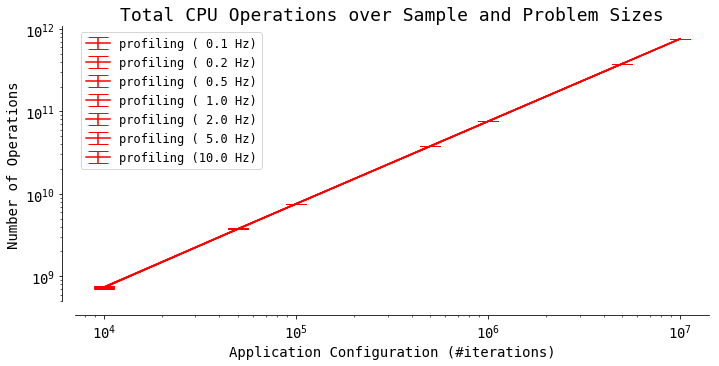

In [26]:
# ---------------------------------------------------------------------------------
# CPU ops

ax_ops = create_figure('Total CPU Operations over Sample and Problem Sizes')
labels = list()
host   = 'thinkie'
mode   = 'pro'
  
for rate in rates:
    
    tmp = f[(f['tag_rate'] == rate) & (f['mode'] == mode) & (f['host'] == host)]
    tmp = tmp[['cpu_ops', 'tag_step']].groupby('tag_step')
        
    tmp_means  = tmp.mean()
    tmp_errors = tmp.std()
        
    # we do not have data for some rates, due to limited db size
    if not len(tmp_means):
        continue

    tmp_means.plot(logy=True, logx=True, yerr=tmp_errors, ax=ax_ops, capsize=10, color=colors[mode])
    labels.append ('%s (%4s Hz)' % (modnames[mode], rate))

ax_ops.set_xlabel("Application Configuration (#iterations)", fontsize=14)
ax_ops.set_ylabel("Number of Operations", fontsize=14)
plt.legend(labels, loc='best', fontsize=12)
plt.savefig('pro_cpu.png', bbox_inches='tight')
plt.savefig('pro_cpu.pdf', bbox_inches='tight')

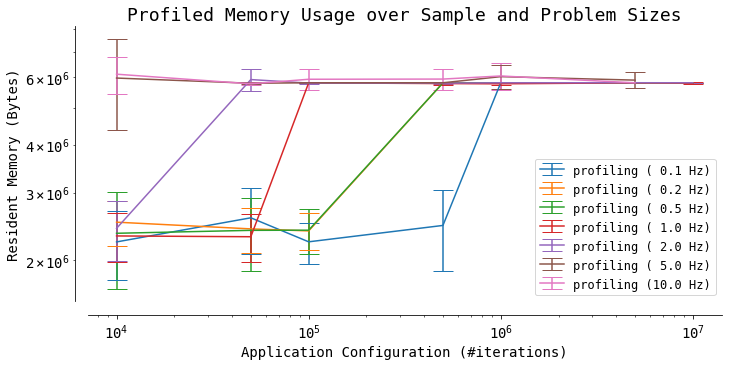

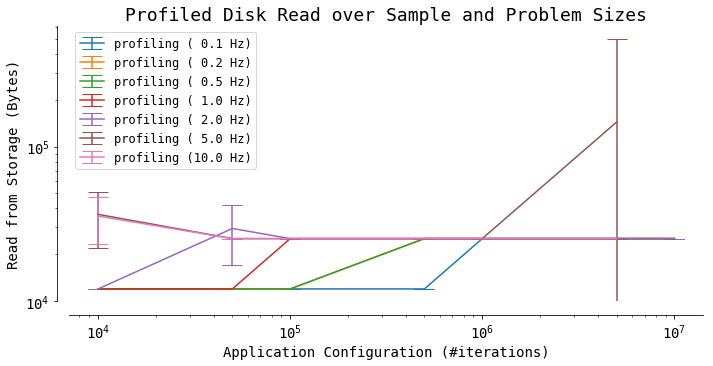

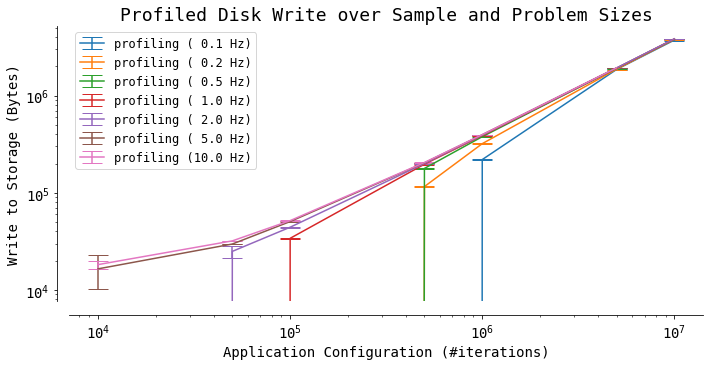

In [27]:
# ---------------------------------------------------------------------------------
# memory

ax_mem = create_figure('Profiled Memory Usage over Sample and Problem Sizes')
labels = list()

for rate in rates:
    
    tmp = f[(f['tag_rate'] == rate) & (f['mode'] == mode) & (f['host'] == host)]
    tmp = tmp[['mem_rss', 'tag_step']].groupby('tag_step')
    
    tmp_means  = tmp.mean()
    tmp_errors = tmp.std()
        
    # we do not have data for some rates, due to limited db size
    if not len(tmp_means):
        continue

    tmp_means.plot(logy=True, logx=True, yerr=tmp_errors, ax=ax_mem, capsize=10)
    labels.append ('%s (%4s Hz)' % (modnames[mode], rate))


ax_mem.set_xlabel("Application Configuration (#iterations)", fontsize=14)
ax_mem.set_ylabel("Resident Memory (Bytes)", fontsize=14)
plt.legend(labels, loc='best', fontsize=12)
plt.savefig('pro_mem.png', bbox_inches='tight')
plt.savefig('pro_mem.pdf', bbox_inches='tight')


# ---------------------------------------------------------------------------------
# sto read

ax_read = create_figure('Profiled Disk Read over Sample and Problem Sizes')
labels = list()

for rate in rates:
    
    tmp = f[(f['tag_rate'] == rate) & (f['mode'] == mode) & (f['host'] == host)]
    tmp = tmp[['sto_read', 'tag_step']].groupby('tag_step')
    
    tmp_means  = tmp.mean()
    tmp_errors = tmp.std()
        
    # we do not have data for some rates, due to limited db size
    if not len(tmp_means):
        continue

    tmp_means.plot(logy=True, logx=True, yerr=tmp_errors, ax=ax_read, capsize=10)
    labels.append ('%s (%4s Hz)' % (modnames[mode], rate))

ax_read.set_xlabel("Application Configuration (#iterations)", fontsize=14)
ax_read.set_ylabel("Read from Storage (Bytes)", fontsize=14)
plt.legend(labels, loc='best', fontsize=12)
plt.savefig('pro_read.png', bbox_inches='tight')
plt.savefig('pro_read.pdf', bbox_inches='tight')


# ---------------------------------------------------------------------------------
# sto write

ax_write = create_figure('Profiled Disk Write over Sample and Problem Sizes')
labels = list()

for rate in rates:
    
    tmp = f[(f['tag_rate'] == rate) & (f['mode'] == mode) & (f['host'] == host)]
    tmp = tmp[['sto_write', 'tag_step']].groupby('tag_step')
    
    tmp_means  = tmp.mean()
    tmp_errors = tmp.std()
        
    # we do not have data for some rates, due to limited db size
    if not len(tmp_means):
        continue

    tmp_means.plot(logy=True, logx=True, yerr=tmp_errors, ax=ax_write, capsize=10)
    labels.append ('%s (%4s Hz)' % (modnames[mode], rate))

ax_write.set_xlabel("Application Configuration (#iterations)", fontsize=14)
ax_write.set_ylabel("Write to Storage (Bytes)",  fontsize=14)
plt.legend(labels, loc='best', fontsize=12)
plt.savefig('pro_write.png', bbox_inches='tight')
plt.savefig('pro_write.pdf', bbox_inches='tight')

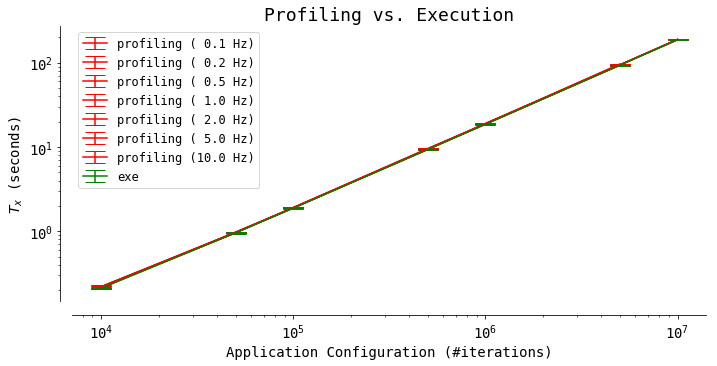

In [83]:
#  \subsubsection{P.1 -- Profiling Overhead}
#
# Figure~\ref{...} compares the TTC for two cases: pure application runs,
# and the execution of the same application on the same resource under
# the synapse profiler.  That measurement is shown for different
# problem sizes (application runtimes) and different sampling rates.
# The graph shows that the overhead introduced by the profiling is 
# negligible and remains so for the investigated range of problem 
# sizes and sampling rates.

host    = 'thinkie'
labels  = list()
host    = 'thinkie'

ax = create_figure('Profiling vs. Execution')

for mode in ['pro', 'exe']:
  
    for rate in rates:
    
        tmp = f[(f['tag_rate'] == rate) & (f['mode'] == mode) & (f['host'] == host)]
        tmp = tmp[['time_real', 'tag_step']].groupby('tag_step')
    
        tmp_means  = tmp.mean()
        tmp_errors = tmp.std()
        
        # we do not have data for some rates, due to limited db size
        if not len(tmp_means):
            continue

        tmp_means.plot(logy=True, logx=True, yerr=tmp_errors, ax=ax, color=colors[mode], capsize=10)
        
        if mode == 'exe':
            labels.append (mode)
        else:
            labels.append ('%s (%4s Hz)' % (modnames[mode], rate))

ax.set_xlabel("Application Configuration (#iterations)", fontsize=14)
ax.set_ylabel("$T_x$ (seconds)", fontsize=14)
plt.legend(labels, loc='best', fontsize=12)
plt.savefig('pro_overhead.png', bbox_inches='tight')
plt.savefig('pro_overhead.pdf', bbox_inches='tight')

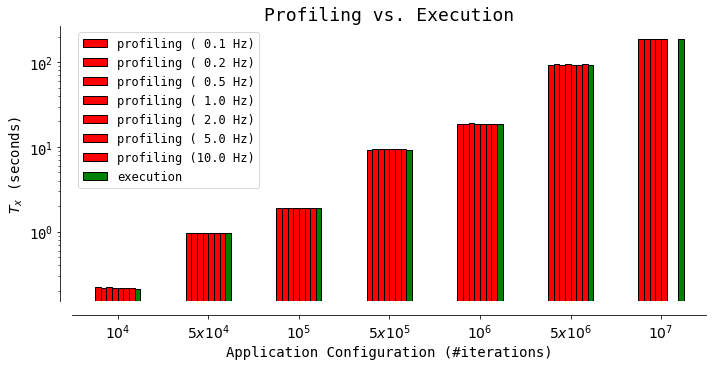

In [84]:
#  \subsubsection{P.1 -- Profiling Overhead}
#
# Figure~\ref{...} compares the TTC for two cases: pure application runs,
# and the execution of the same application on the same resource under
# the synapse profiler.  That measurement is shown for different
# problem sizes (application runtimes) and different sampling rates.
# The graph shows that the overhead introduced by the profiling is 
# negligible and remains so for the investigated range of problem 
# sizes and sampling rates.

my_labels = list()
my_colors = list()
host      = 'thinkie'

ax = create_figure('Profiling vs. Execution')

df = pd.DataFrame()
#for mode in ['pro', 'exe']:
for mode in ['pro', 'exe']:
    
    tmp_rates = rates
    if mode == 'exe':
        tmp_rates = [1]

    for rate in tmp_rates:
        
        idx = '%s (%4s Hz)' % (modnames[mode], rate)
        if mode == 'exe':
            idx = 'execution'

        tmpf = f[(f['host'] == host) & (f['mode'] == mode)][['time_real', 'tag_step', 'tag_rate']]

      # print tmpf
        tmp = tmpf[(tmpf['tag_rate'] == rate)].groupby('tag_step')
        means = tmp.mean()
        df[idx] = means['time_real']

        my_labels.append (idx)
        my_colors.append (colors[mode])

df.plot(logx=False, logy=True, kind='bar', ax=ax, color=my_colors, edgecolor=['black'], linewidth=1.0
)

ax.set_xticklabels(['$10^4$', '$5x10^4$', '$10^5$', '$5x10^5$', '$10^6$', '$5x10^6$', '$10^7$'], rotation=0)
ax.set_xlabel("Application Configuration (#iterations)", fontsize=14)
ax.set_ylabel("$T_x$ (seconds)", fontsize=14)
plt.legend(my_labels, loc='best', fontsize=12)
plt.savefig('pro_overhead_bars.png', bbox_inches='tight')
plt.savefig('pro_overhead_bars.pdf', bbox_inches='tight')

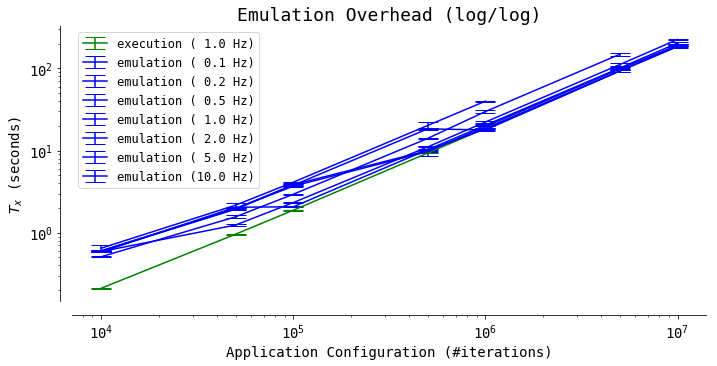

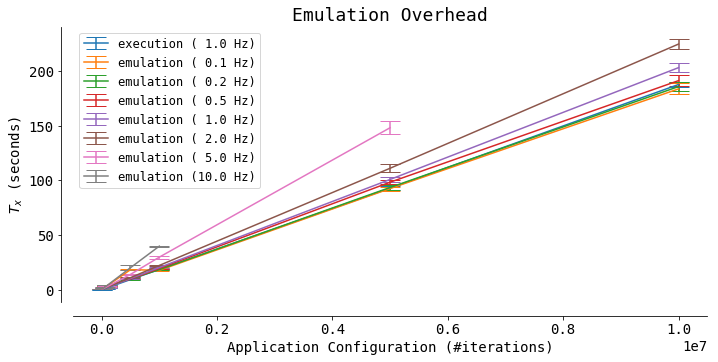

In [85]:
# \subsubsection{P.3/E.1 -- Profiling as Emulation Input}
# 
# The ultimate purpose of synapse's profiling is to feed synapse's
# emulation.  Figure~\ref{...} compares the TTC of pure application
# execution versus emulated application runs, on the very machine used
# for application profiling.  The graphs show that emulation tends to 
# incur an overhead, specifically if very high sampling rates are used.
# That can be explained by the added communication overhead between
# the sampling threads and processes, which is additional to the 
# profiled resource consumption of the application.

host   = 'thinkie'
labels = list()

ax1 = create_figure('Emulation Overhead (log/log)')


for mode in ['exe', 'emu']:
  
    for rate in rates:
    
        tmp = f[(f['tag_rate'] == rate) & (f['mode'] == mode) & (f['host'] == host)]
        tmp = tmp[['time_real', 'tag_step']].groupby('tag_step')
        
        tmp_means  = tmp.mean()
        tmp_errors = tmp.std()
        
        if not len(tmp_means):
            continue

        tmp_means.plot(logy=True,  logx=True,  yerr=tmp_errors, ax=ax1, capsize=10, color=colors[mode])
        labels.append ('%s (%4s Hz)' % (modnames[mode], rate))

ax1.set_xlabel("Application Configuration (#iterations)", fontsize=14)
ax1.set_ylabel("$T_x$ (seconds)",                  fontsize=14)
plt.legend(labels, loc='best', fontsize=12)

# same w/o log

labels=list()
ax2 = create_figure('Emulation Overhead')
for mode in ['exe', 'emu']:
  
    for rate in rates:
    
        tmp = f[(f['tag_rate'] == rate) & (f['mode'] == mode) & (f['host'] == host)]
        tmp = tmp[['time_real', 'tag_step']].groupby('tag_step')
        
        tmp_means  = tmp.mean()
        tmp_errors = tmp.std()
        
        if not len(tmp_means):
            continue

        tmp_means.plot(logy=False, logx=False, yerr=tmp_errors, ax=ax2, capsize=10)
        labels.append ('%s (%4s Hz)' % (modnames[mode], rate))

ax2.set_xlabel("Application Configuration (#iterations)", fontsize=14)
ax2.set_ylabel("$T_x$ (seconds)", fontsize=14)
plt.legend(labels, loc='best', fontsize=12)

plt.savefig('emu_overhead.png', bbox_inches='tight')
plt.savefig('emu_overhead.pdf', bbox_inches='tight')

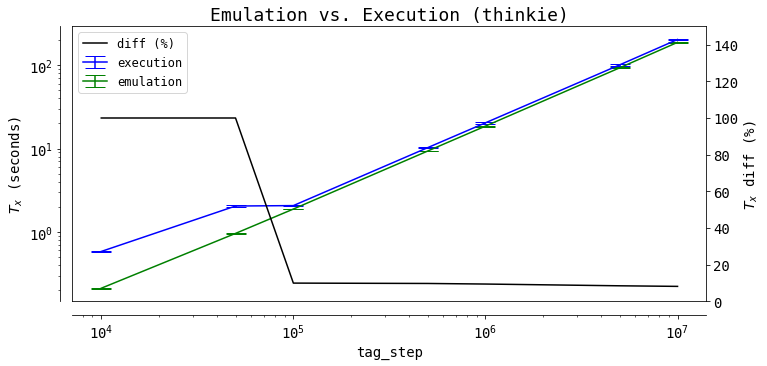

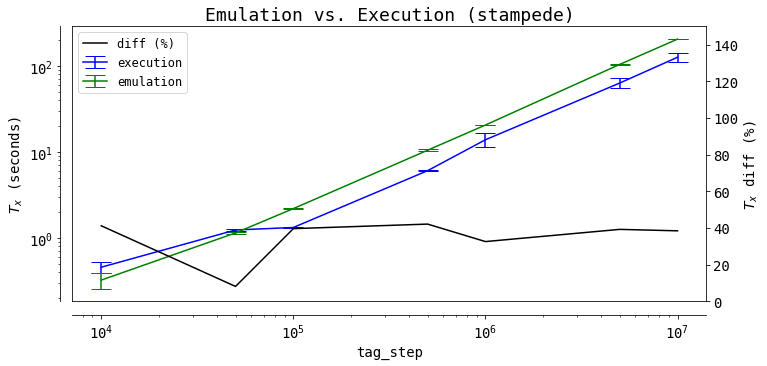

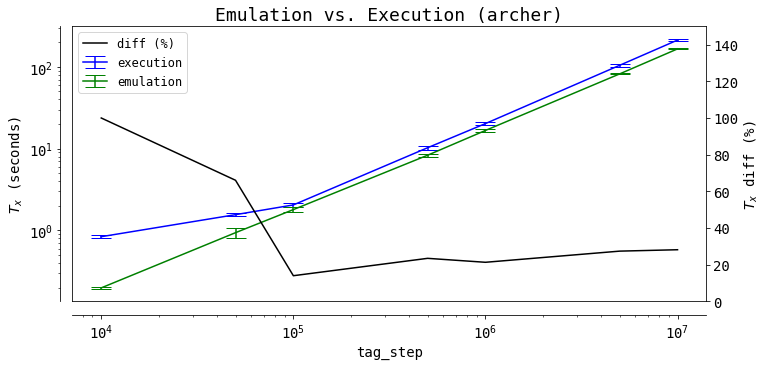

In [86]:
# \subsubsection{P.4/E.1 -- Profiling as Emulation Input}
# 
# Similar to figure~\ref{...}, figure~\ref{...} compares the
# application execution and application emulation on resources
# \I{different} than the one used for application profiling, ie. on
# Stampede and Archer.  Again the TTCs for application execution
# and emulation are resambling the application characteristics 
# over a range of application sizes and sampling rates.
#
# The plots though also show that the emulation overhead is 
# significant for small application sizes, ie. for application 
# runtimes of about one second or smaller.  We find that acceptable, 
# as our research focus lies on much longer living applications, and
# we assume that sub-second application runs will remain the exception
# in both HTDC and HPDC\F{acronyms}.

for host in hosts:
    emuf = host_frames[host]['emu']
    emu  = emuf[['time_real', 'tag_step']].groupby('tag_step')
        
    emu_means  = emu.mean()
    emu_errors = emu.std()

    exef = host_frames[host]['exe']
    exe  = exef[['time_real', 'tag_step']].groupby('tag_step')

    exe_means  = exe.mean()
    exe_errors = exe.std()

    ax = create_figure('Emulation vs. Execution (%s)' % host)
    ax.set_xlabel("Application Configuration (#iterations)", fontsize=14)
    ax.set_ylabel("$T_x$ (seconds)", fontsize=14)
    
    labels = list()
    handles = list()

    print_delta=True
    if print_delta:
        delta = 100 * abs(exe_means['time_real'] - emu_means['time_real']) / exe_means['time_real']
        delta = delta.clip(upper=100)
    
        ax.plot(1, color=colors['diff']) # NOTE: this is to get the diff label right :(
        h = delta.plot(logx=True, logy=False, label='diff', ax=ax, color=colors['diff'], secondary_y=True)
        handles.append(h)
        
        ax.right_ax.set_ylabel("$T_x$ diff (%)", fontsize=14)
        ax.right_ax.set_ylim((0,150))

        labels.append('diff (%)')

    
    emu_means.plot(logx=True, logy=True,  label='emu',  ax=ax, color=colors['emu'], yerr=emu_errors, capsize=10)
    exe_means.plot(logx=True, logy=True,  label='exe',  ax=ax, color=colors['exe'], yerr=exe_errors, capsize=10)
    labels.extend(['execution', 'emulation'])
    
    ax.legend(labels, loc='upper left', fontsize=12)

    plt.savefig('emu_vs_exe_%s.png' % host, bbox_inches='tight')
    plt.savefig('emu_vs_exe_%s.pdf' % host, bbox_inches='tight')